In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns
# sns.set_context('talk')
import scipy.stats as ss
import math

from scipy.integrate import simpson, trapezoid
import numpy as np
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import gaussian_kde

import riskDualObserverShared as model
import tools as tools

In [2]:
import riskDualObserverShared as model
import tools as tools

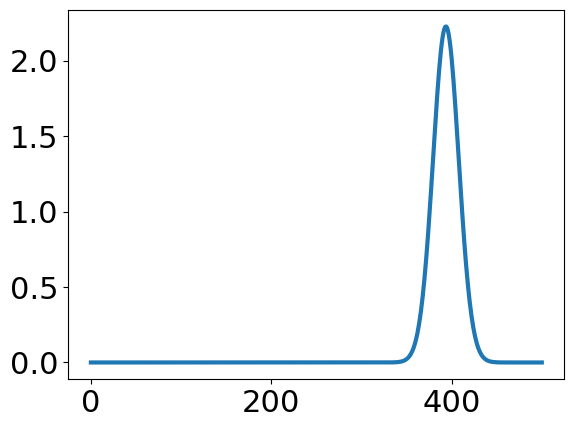

In [3]:
p_mOri_given_theta0, p_mOri_given_theta = model.MI_orientation_encoding(0.8*np.pi, 1000, 32, normalize = False)

plt.plot(p_mOri_given_theta[400])


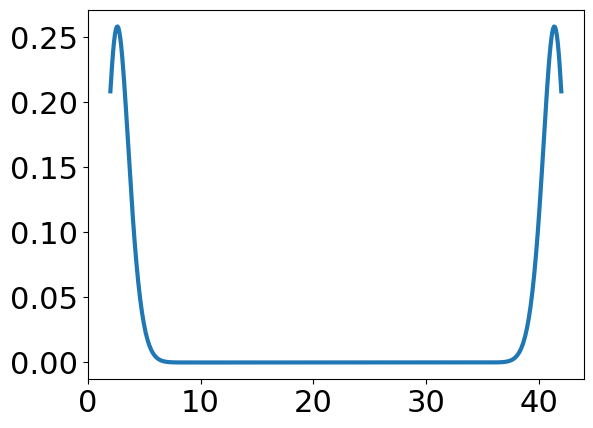

In [4]:
p_mVal_given_theta0, p_mVal_given_val = model.val_encoded(0.9*np.pi, 10000, 32, np.sqrt(tools.factor_val/64), "linearIncrease")

# plt.plot(tools.rep_val_grid, p_mVal_given_theta0[0])
plt.plot(tools.rep_val_grid, p_mVal_given_val[500])


2.0


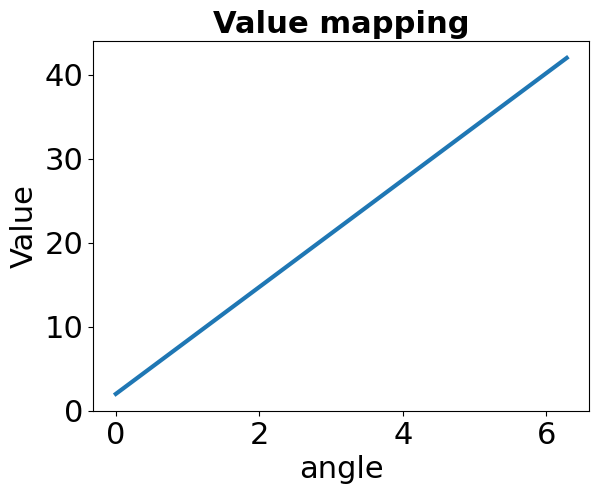

In [5]:
type = "linearIncrease"
line_frac = 0.0

plt.plot(tools.stim_ori_grid, tools.value_function_ori(tools.stim_ori_grid, type, line_frac))
# plt.plot(tools.stim_ori_grid, tools.value_function_ori(tools.stim_ori_grid, "cdf_prior", line_frac))
# plt.plot(tools.stim_ori_grid,(integrate.cumtrapz(tools.prior_ori(tools.stim_ori_grid), tools.stim_ori_grid, initial=0.0))*tools.factor_val+tools.min_val)

print(min(tools.value_function_ori(tools.stim_ori_grid, type, line_frac)))

plt.ylabel("Value")
plt.xlabel("angle")
plt.title("Value mapping", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")

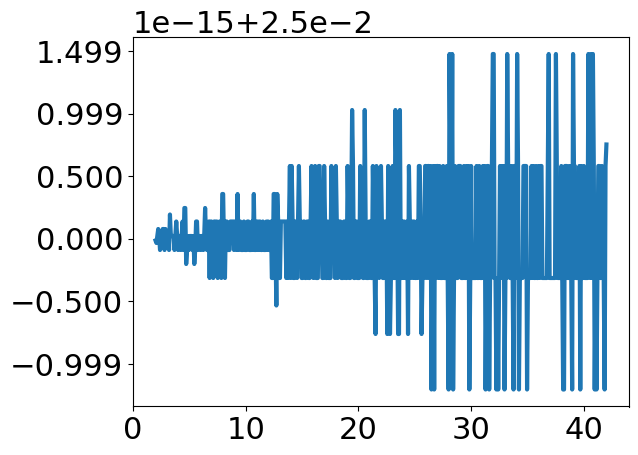

In [6]:
plt.plot(tools.prior_val("linearIncrease")[0], tools.prior_val("linearIncrease")[1])
# model.prior_val("inversePrior")[0]

(1, 501)

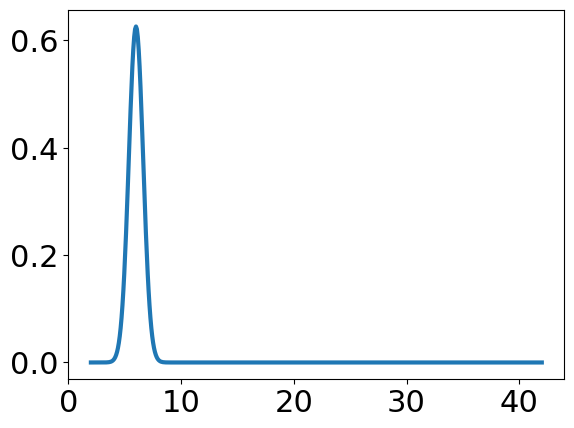

In [7]:

theta0 = 0.2*np.pi
kappa_s = 100
type = "linearIncrease"

bin_centers, ps = tools.ori_to_val_dist(model.stim_ori_grid, tools.stimulus_ori_noise(theta0, kappa_s, model.stim_ori_grid), type, monotonic=True)


plt.plot(bin_centers, ps[0])

np.shape(bin_centers)
np.shape(ps)



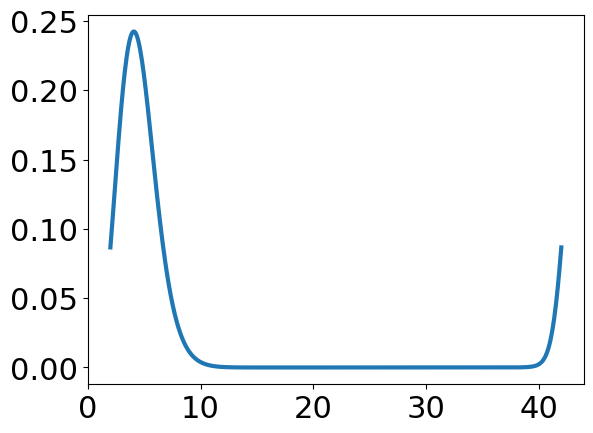

In [8]:
theta0 = 10/90*np.pi
kappa_s = 1000
kappa_r = 32
sigma_rep = np.sqrt(tools.factor_val/64)
type = "linearIncrease"

# rep_val_grid, p_mVal_given_Val0, p_mVal_given_Val = model.val_encoded(theta0, kappa_s, kappa_r,sigma_rep, type)
stim_val_grid, p_value_est_given_val0 = model.value_bayesian_decoding(theta0, kappa_s, kappa_r, sigma_rep, type)

# p_mOri_given_theta0, p_mOri_given_theta = model.MI_orientation_encoding(theta0, kappa_s, kappa_r, sigma_rep)

# plt.plot(rep_val_grid, p_mVal_given_Val0[0])

plt.plot(stim_val_grid, p_value_est_given_val0[0])

# plt.plot(p_mOri_given_theta0[0])


70.0
96.47999999999999


array([[0.55912796]])

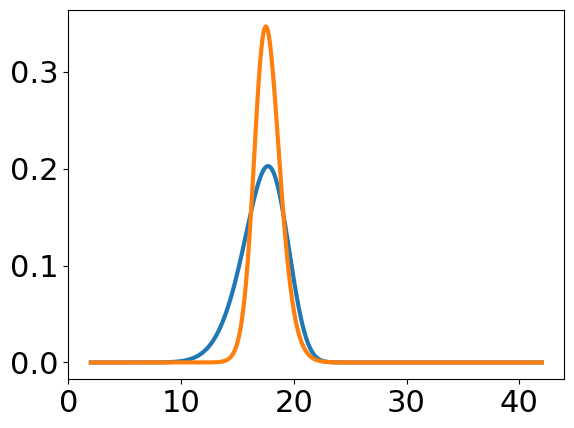

In [9]:
theta0 = 70./90.*np.pi
kappa_s = 10000
kappa_r = 32
sigma_rep = np.sqrt(tools.factor_val/64)
type = "linearIncrease"
risk_prob = 0.75
theta1 = float(tools.inverse_monotonic(tools.value_function_ori(theta0, type)/risk_prob, type)) 

print(theta0*90/np.pi)
print(theta1*90/np.pi)

safe_value, safe_prob = model.safe_value_dist(theta0, kappa_s, kappa_r, sigma_rep, type)
risky_value, risky_prob = model.risky_value_dist(theta1, kappa_s, kappa_r, sigma_rep, risk_prob, type)

plt.plot(safe_value, safe_prob[0])
plt.plot(safe_value, risky_prob[0])

p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
p_chose_risky

# tools.get_rnp(safe_value, risky_value)
# plt.plot(rep_val_grid, p_mVal_given_Val0[0])
# plt.plot(stim_val_grid, p_val_given_mVal[40])
# plt.plot(stim_val_grid, abs(trapezoid((p_mVal_given_Val0[:,np.newaxis,:]*p_val_given_mVal[np.newaxis, ...]),rep_val_grid,axis = 2)[0]))
# plt.plot(stim_val_grid, p_value_est_given_val0[0])

# Uncovering risk attitudes

# Comaparing two models - Both safe and risky option with same noise type

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns
# sns.set_context('talk')
import scipy.stats as ss
import math

from scipy.integrate import simpson, trapezoid
import numpy as np
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import gaussian_kde

import riskDualObserverShared as model
import tools as tools

In [2]:
def rnp_across_safeVals(stim_noise, rep_ori_noise, rep_val_noise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])-1
    start = int(experimentEffects[0:2])+1
    end = end/90.*np.pi
    start = start/90.*np.pi
    
    if (type=="prior" or type=="curvedPrior" or type =="linearDecrease"):
        start_safe = float(tools.inverse_monotonic(tools.value_function_ori(start, type)/1.5, type))
        safe_angles =  np.linspace(end, start_safe, int((end*90/np.pi-start_safe*90/np.pi+1)/3))
    else:
        end_safe = float(tools.inverse_monotonic(tools.value_function_ori(end, type)/1.5, type))
        safe_angles =  np.linspace(start, end_safe, int((start*90/np.pi+end_safe*90/np.pi-1)/3))
    
    # print("safe angles - ",safe_angles)
    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
        if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval), 20)
        else:
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval), 20)

        # print("range - ", rangeOri)
        # print("interval - ",interval)

        safeVal = float(tools.value_function_ori(safe_angles[i], type))
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # getting inferred safe values
        safe_value, safe_prob = model.safe_value_dist(safe_angles[i], stim_noise, rep_ori_noise, rep_val_noise , type)
        rr, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_ori_noise, rep_val_noise, risk_prob, type)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        print("safe angle - ", safe_angles[i]*90./np.pi)
        # print(p_chose_risky[0,::2])
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
        print(rnp[i])

    return safe_angles, safeVals, rnp



safe angle -  1.0
0.04592421698144816
safe angle -  4.125882352941177
0.6666590296435334
safe angle -  7.251764705882353
0.7365978173016914
safe angle -  10.377647058823527
0.7495579259019397
safe angle -  13.503529411764706
0.7476283096123607
safe angle -  16.629411764705882
0.7389986788707634
safe angle -  19.755294117647058
0.7292777755149489
safe angle -  22.881176470588237
0.7220867087760137
safe angle -  26.00705882352941
0.7189723429274731
safe angle -  29.132941176470585
0.7194814284947044
safe angle -  32.258823529411764
0.7224141983784743
safe angle -  35.38470588235294
0.7265437378634307
safe angle -  38.510588235294115
0.7307988633590449
safe angle -  41.63647058823529
0.7350467805139539
safe angle -  44.76235294117647
0.7390330667954966
safe angle -  47.88823529411764
0.742888918276246
safe angle -  51.014117647058825
0.7466475018541737
safe angle -  54.13999999999999
0.7503789827709603
safe angle -  57.265882352941176
0.7539719604795035
safe angle -  60.391764705882345
0.

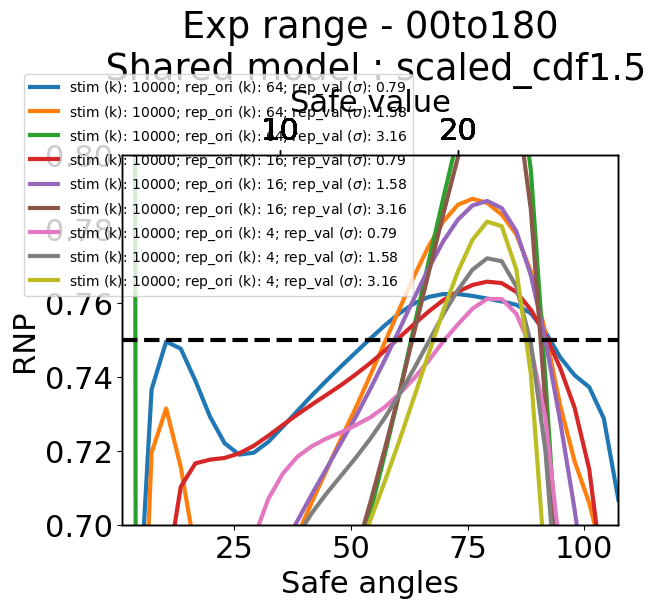

In [3]:
# setting parameters
experimentEffects = tools.experimentRange #"00to45"
risk_prob = 0.75
# type = "curved_cdf_prior" 

types = ["cdf_prior", "scaled_cdf"]
# type = "curved_cdf_prior"

for type in types:

    # changeable parameters
    stim_list = [10000]
    rep_ori_list = [64, 16, 4]
    rep_val_list = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]
    # high stim noise
    # stim_list = [64, 16, 8, 4]
    # rep_ori_list = [128]
    # rep_val_list = [np.sqrt(tools.factor_val/128)]


    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    for stim_noise in stim_list:
        for rep_ori_noise in rep_ori_list:
            for rep_val_noise in rep_val_list:

                safe_angles, safeVals, rnp = rnp_across_safeVals(stim_noise, rep_ori_noise, rep_val_noise, type, risk_prob, experimentEffects)
                ax1.set_ylim(0.7, 0.8)
                ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

                text = "stim (k): "+ str(stim_noise)+"; rep_ori (k): "+str(round(rep_ori_noise,2))+"; rep_val ($\sigma$): "+str(round(rep_val_noise,2))
                ax1.plot(safe_angles[:]*90./np.pi, rnp[:], label = text)


                ax2 = ax1.twiny()
                if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
                    ax2.set_xlim(max(safeVals), min(safe_angles))

                ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)

    ax1.axhline(risk_prob, c='k', ls='--')
    ax1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})

    ax2.set_xlabel("Safe value")
    ax1.set_xlabel("Safe angles")
    ax1.set_ylabel("RNP")

    if type == "scaled_cdf":
        ax1.set_title("Exp range - " + tools.experimentRange + "\n Shared model : " + type+str(tools.scaling)) 
    else:
        ax1.set_title("Exp range - " + tools.experimentRange + "\n Shared model : " + type) 


    plt.savefig("/Users/sbedi/Downloads/"+tools.contextual_prior+"-shared-"+type+".png",dpi=300, bbox_inches = "tight")
